In [1]:
import numpy as np
import cvxpy as cp
import pandapower as pp
import networkx as nx
import pandas as pd
import copy
import matplotlib.pyplot as plt


In [2]:
import pandapower as pp
import pandapower.topology as top
import networkx as nx

def set_switch_states(net):
    """
    Sets up switches for the network as follows:
      - Creates bus–bus switches for R14-I1, I2-c3, and R9-c5.
      - Creates a line switch for the physical line between R13 and R14.
      - Sets the desired states:
          * R14-I1: closed (connection active)
          * I2-c3: open (disconnected)
          * R9-c5: closed (connection active)
          * R13-R14: open (line disconnect controlled via the switch)
    """
    # -------------------------------
    # Retrieve Bus Indices Using Bus Names
    # -------------------------------
    bus_R14 = net.bus.index[net.bus["name"] == "Bus R14"][0]
    bus_I1  = net.bus.index[net.bus["name"] == "Bus I1"][0]
    bus_I2  = net.bus.index[net.bus["name"] == "Bus I2"][0]
    bus_c3  = net.bus.index[net.bus["name"] == "Bus C3"][0]
    bus_R9  = net.bus.index[net.bus["name"] == "Bus R9"][0]
    bus_c5  = net.bus.index[net.bus["name"] == "Bus C5"][0]
    bus_R13 = net.bus.index[net.bus["name"] == "Bus R13"][0]
    
    # -------------------------------
    # Create Bus–Bus Switches (et = "b")
    # -------------------------------
    # Switch between R14 and I1 (note: bus–bus switch, since no physical line exists)
    switch_R14_I1 = pp.create_switch(net, bus=bus_I1, element=bus_R14, et="b",
                                     closed=True, type="CB", name="Switch R14-I1")
    # Switch between I2 and c3
    switch_I2_c3 = pp.create_switch(net, bus=bus_I2, element=bus_c3, et="b",
                                    closed=True, type="CB", name="Switch I2-c3")
    # Switch between R9 and c5
    switch_R9_c5 = pp.create_switch(net, bus=bus_R9, element=bus_c5, et="b",
                                    closed=True, type="CB", name="Switch R9-c5")
    
    # -------------------------------
    # Create a Line Switch for R13-R14 (et = "l")
    # -------------------------------
    # For R13-R14, there is a physical line in net.line.
    # Instead of removing it from service, we attach a switch to control it.
    line_candidates = net.line[
        ((net.line.from_bus == bus_R13) & (net.line.to_bus == bus_R14)) |
        ((net.line.from_bus == bus_R14) & (net.line.to_bus == bus_R13))
    ]
    if line_candidates.empty:
        print("No physical line found between Bus R13 and Bus R14. Cannot create a line switch.")
    else:
        # Use the first candidate line
        line_idx = line_candidates.index[0]
        switch_R13_R14 = pp.create_switch(net, bus=bus_R13, element=line_idx, et="l",
                                          closed=True, type="CB", name="Switch R13-R14")
    
    # -------------------------------
    # Set Desired Switch States
    # -------------------------------
    net.switch.at[switch_R14_I1, 'closed'] = True    # R14-I1: closed (connection active)
    net.switch.at[switch_I2_c3, 'closed']  = False     # I2-c3: open (disconnected)
    net.switch.at[switch_R9_c5, 'closed']  = False      # R9-c5: closed (connection active)
    if not line_candidates.empty:
        net.switch.at[switch_R13_R14, 'closed'] = False  # R13-R14 line switch: open (disconnects the line)
    
    # Print the switch table to verify states
    print("\nSwitch Table:")
    print(net.switch[['name', 'bus', 'element', 'closed']])

def check_radiality(net):
    """
    Checks if the network is radial (i.e., forms a tree) based on the current switch states.
    """
    G = top.create_nxgraph(net, respect_switches=True)
    if nx.is_tree(G):
        print("The network is radial (a tree).")
    else:
        print("The network is NOT radial (loops detected).")
    print("Graph edges:", list(G.edges()))

# -------------------------------
# Main Code
# -------------------------------
net_file_path = "./modified_cigre_network_lv.p"
net = pp.from_pickle(net_file_path)

# Set switch states based on the desired configuration
set_switch_states(net)

# Optionally, run a power flow here if needed (pp.runpp(net))
# Check radiality of the network after switch configuration
check_radiality(net)



Switch Table:
             name  bus  element  closed
0              S1    0        1    True
1              S2    0       20    True
2              S3    0       23    True
3   Switch R14-I1   21       15    True
4    Switch I2-c3   22       26   False
5    Switch R9-c5   10       28   False
6  Switch R13-R14   14       12   False
The network is radial (a tree).
Graph edges: [(np.int64(2), np.int64(3)), (np.int64(2), np.int64(1)), (np.int64(3), np.int64(4)), (np.int64(4), np.int64(5)), (np.int64(4), np.int64(12)), (np.int64(5), np.int64(6)), (np.int64(5), np.int64(13)), (np.int64(6), np.int64(7)), (np.int64(7), np.int64(8)), (np.int64(7), np.int64(17)), (np.int64(8), np.int64(9)), (np.int64(9), np.int64(10)), (np.int64(10), np.int64(11)), (np.int64(10), np.int64(18)), (np.int64(11), np.int64(19)), (np.int64(13), np.int64(14)), (np.int64(15), np.int64(16)), (np.int64(15), np.int64(21)), (np.int64(21), np.int64(22)), (np.int64(21), np.int64(20)), (np.int64(24), np.int64(25)), (np.int64

In [3]:
import pyomo.environ as pyo
import networkx as nx

# ----- 1. Define a Simple IEEE 13-Bus Network (Dummy Data) -----
# Buses 1 to 13
B = list(range(1, 14))

# Candidate edges representing potential switch locations.
# These edges are chosen to form a spanning tree.
candidate_edges = {
    (1, 2), (2, 3), (2, 4), (4, 5), (4, 6), (4, 7),
    (7, 8), (7, 9), (9, 10), (9, 11), (9, 12), (11, 13)
}
# Ensure edges are stored as unordered pairs.
S = {(min(i, j), max(i, j)) for (i, j) in candidate_edges}

# For each undirected edge, create two directed edges.
directed_edges = []
for (i, j) in S:
    directed_edges.append((i, j))
    directed_edges.append((j, i))

# ----- 2. Define Net Injections at Each Bus (Dummy Values) -----
# Net injection = generation - load.
# For a feasible power balance, the sum over all buses must be zero.
# Here we assume bus 1 is slack and buses 2 to 12 are loads.
S_load = {
    1:  0.0, 
    2: -1.0, 
    3: -0.5, 
    4: -0.2, 
    5: -0.3, 
    6: -0.4,
    7: -0.6, 
    8: -0.2, 
    9: -0.7, 
    10:-0.2, 
    11:-0.3, 
    12:-0.1, 
    13:  4.5  # Adjusted so that the total sum is 0: 0 - 1 - 0.5 - ... - 0.1 + 4.1 = 0
}

# ----- 3. Set Up the Optimization Model in Pyomo -----
model = pyo.ConcreteModel()

# Define sets for buses, candidate (undirected) edges, and directed edges.
model.B = pyo.Set(initialize=B)
model.S = pyo.Set(initialize=list(S), dimen=2)
model.D = pyo.Set(initialize=directed_edges, dimen=2)

# Binary variable: x[s] = 1 if candidate edge s (switch) is closed.
model.x = pyo.Var(model.S, domain=pyo.Binary)
# Continuous variable: f[i,j] is the power flow on directed edge (i,j).
model.f = pyo.Var(model.D, domain=pyo.NonNegativeReals)

# Big-M constant – choose a number larger than any expected flow.
M = 1000

# 3a. Capacity Constraint: If a switch is open, no flow can pass.
def capacity_rule(model, i, j):
    s = (min(i, j), max(i, j))
    return model.f[i, j] <= M * model.x[s]
model.capacity = pyo.Constraint(model.D, rule=capacity_rule)

# 3b. Node Power Balance Constraint:
# For each bus i, the net flow (inflow minus outflow) must equal S_load[i].
def node_balance_rule(model, i):
    inflow = sum(model.f[j, i] for j in B if (j, i) in model.D)
    outflow = sum(model.f[i, j] for j in B if (i, j) in model.D)
    return inflow - outflow == S_load[i]
model.node_balance = pyo.Constraint(model.B, rule=node_balance_rule)

# 3c. Spanning Tree Constraint:
# In a tree with 13 buses, there must be exactly 12 closed edges.
def tree_edge_count_rule(model):
    return sum(model.x[s] for s in model.S) == len(B) - 1
model.tree_edge_count = pyo.Constraint(rule=tree_edge_count_rule)

# 3d. Objective Function:
# Minimize the total transmitted power (sum of flows on all directed edges).
def obj_rule(model):
    return sum(model.f[i, j] for (i, j) in model.D)
model.obj = pyo.Objective(rule=obj_rule, sense=pyo.minimize)

# ----- 4. Solve the Optimization Model -----
solver = pyo.SolverFactory('glpk')
results = solver.solve(model, tee=True)
print("Solver Status:", results.solver.status)
print("Termination Condition:", results.solver.termination_condition)

if results.solver.termination_condition != pyo.TerminationCondition.optimal:
    raise ValueError("The optimization problem did not converge to an optimal solution.")

# Retrieve the candidate edges (closed switches) where x[s] = 1.
selected_edges = [s for s in model.S if pyo.value(model.x[s]) > 0.5]
print("\nSelected candidate edges (closed switches):", selected_edges)

# ----- 5. (Optional) Build a NetworkX Graph to Check Radiality -----
G = nx.Graph()
G.add_nodes_from(B)
G.add_edges_from(selected_edges)
if nx.is_tree(G):
    print("\nThe resulting configuration is radial (a spanning tree).")
else:
    print("\nThe resulting configuration is NOT radial (loops exist).")
print("Graph edges:", list(G.edges()))


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpfv543r9s.glpk.raw --wglp /tmp/tmp2if1goav.glpk.glp --cpxlp
 /tmp/tmprn7wpb7n.pyomo.lp
Reading problem data from '/tmp/tmprn7wpb7n.pyomo.lp'...
/tmp/tmprn7wpb7n.pyomo.lp:292: warning: lower bound of variable 'x27' redefined
/tmp/tmprn7wpb7n.pyomo.lp:292: warning: upper bound of variable 'x27' redefined
38 rows, 36 columns, 108 non-zeros
12 integer variables, all of which are binary
304 lines were read
Writing problem data to '/tmp/tmp2if1goav.glpk.glp'...
270 lines were written
GLPK Integer Optimizer 5.0
38 rows, 36 columns, 108 non-zeros
12 integer variables, all of which are binary
Preprocessing...
16 rows, 24 columns, 51 non-zeros
0 integer variables, none of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 13
Solving LP relaxation...
GLPK Simplex Optimiz

In [4]:
import pandapower as pp
import pandapower.topology as top
import networkx as nx

def set_switch_states(net):
    """
    1) Create and control bus–bus switches.
    2) Remove (set out of service) the physical line between specific buses so that
       a dedicated switch governs connectivity.
    """
    # -------------------------------
    # 1. Bus–Bus Switches for defined bus pairs
    # -------------------------------
    # Retrieve bus indices using bus names (adjust names as per your net.bus "name" column)
    bus_R14 = net.bus.index[net.bus["name"] == "Bus R14"][0]
    bus_I1  = net.bus.index[net.bus["name"] == "Bus I1"][0]
    bus_I2  = net.bus.index[net.bus["name"] == "Bus I2"][0]
    bus_c3  = net.bus.index[net.bus["name"] == "Bus C3"][0]
    bus_R9  = net.bus.index[net.bus["name"] == "Bus R9"][0]
    bus_c5  = net.bus.index[net.bus["name"] == "Bus C5"][0]
    bus_R13 = net.bus.index[net.bus["name"] == "Bus R13"][0]  # For the R13-R14 connection

    # Create switches for the already defined pairs
    switch_R14_I1 = pp.create_switch(net, bus=bus_I1, element=bus_R14, et="b",
                                     closed=True, type="CB", name="Switch R14-I1")
    switch_I2_c3  = pp.create_switch(net, bus=bus_I2, element=bus_c3, et="b",
                                     closed=True, type="CB", name="Switch I2-c3")
    switch_R9_c5  = pp.create_switch(net, bus=bus_R9, element=bus_c5, et="b",
                                     closed=True, type="CB", name="Switch R9-c5")
    # Create a dedicated switch between R13 and R14.
    switch_R13_R14 = pp.create_switch(net, bus=bus_R13, element=bus_R14, et="b",
                                      closed=True, type="CB", name="Switch R13-R14")
    
    # Set the desired states:
    # For example, you can control these as needed:
    net.switch.at[switch_R14_I1, 'closed'] = True    # R14-I1 is closed (connected)
    net.switch.at[switch_I2_c3, 'closed'] = False      # I2-c3 is open (disconnected)
    net.switch.at[switch_R9_c5, 'closed'] = False       # R9-c5 is open (disconnected)
    net.switch.at[switch_R13_R14, 'closed'] = False      # Switch R13-R14 is closed (connection active)

    # -------------------------------
    # 2. Remove the physical line between R13 and R14
    # -------------------------------
    # Find any line(s) that connect Bus R13 and Bus R14.
    line_candidates = net.line[
        ((net.line.from_bus == bus_R13) & (net.line.to_bus == bus_R14)) |
        ((net.line.from_bus == bus_R14) & (net.line.to_bus == bus_R13))
    ]
    if line_candidates.empty:
        print("No physical line found between Bus R13 and Bus R14.")
    else:
        for idx in line_candidates.index:
            net.line.at[idx, 'in_service'] = False
            print(f"Line {idx} between Bus R13 and Bus R14 is now out of service.")

    # Print the switch table to verify states
    print("\nSwitch Table:")
    print(net.switch[['name', 'bus', 'element', 'closed']])
    
# ----- Main Code -----
# Assume 'net' is already loaded from your file.
#set_switch_states(net)  # Call this before checking radiality

# Now, check if the network is radial using pandapower's topology functions.
def check_radiality(net):
    # Create a NetworkX graph that respects the switch states and line in_service flags.
    G = top.create_nxgraph(net, respect_switches=True)
    if nx.is_tree(G):
        print("The network is radial (a tree).")
    else:
        print("The network is NOT radial (loops detected).")
    # For debugging, you can print the graph's edges:
    print("Graph edges:", list(G.edges()))

# Example usage:

net_file_path = "./modified_cigre_network_lv.p"
net = pp.from_pickle(net_file_path)
set_switch_states(net)
check_radiality(net)


Line 12 between Bus R13 and Bus R14 is now out of service.

Switch Table:
             name  bus  element  closed
0              S1    0        1    True
1              S2    0       20    True
2              S3    0       23    True
3   Switch R14-I1   21       15    True
4    Switch I2-c3   22       26   False
5    Switch R9-c5   10       28   False
6  Switch R13-R14   14       15   False
The network is radial (a tree).
Graph edges: [(np.int64(2), np.int64(3)), (np.int64(2), np.int64(1)), (np.int64(3), np.int64(4)), (np.int64(4), np.int64(5)), (np.int64(4), np.int64(12)), (np.int64(5), np.int64(6)), (np.int64(5), np.int64(13)), (np.int64(6), np.int64(7)), (np.int64(7), np.int64(8)), (np.int64(7), np.int64(17)), (np.int64(8), np.int64(9)), (np.int64(9), np.int64(10)), (np.int64(10), np.int64(11)), (np.int64(10), np.int64(18)), (np.int64(11), np.int64(19)), (np.int64(13), np.int64(14)), (np.int64(15), np.int64(16)), (np.int64(15), np.int64(21)), (np.int64(21), np.int64(22)), (np.int64(

In [5]:
#!/usr/bin/env python3
"""
Complete Pyomo model for an 8-bus distribution network with switchable lines.
This code uses a simplified DistFlow formulation and includes a slack bus voltage constraint.
It defines a directed edge set for orientation constraints to enforce a radial (tree) structure.
"""

from pyomo.environ import (
    ConcreteModel, Set, Param, Var, Binary, NonNegativeReals, Reals,
    Objective, Constraint, minimize, SolverFactory, value
)

def create_model():
    # -----------------------------
    # 1) Create the Pyomo model
    # -----------------------------
    model = ConcreteModel("Distribution_Network")

    # -----------------------------
    # 2) Define the data in Python
    # -----------------------------
    # Buses: 0 is the slack bus
    buses = [0, 1, 2, 3, 4, 5, 6, 7]
    slack_buses = [0]

    # Undirected lines (each tuple is (i,j) with i < j)
    lines = [
        (0, 1),
        (1, 2),
        (1, 3),
        (2, 4),
        (2, 5),
        (3, 6),
        (4, 7),
        (5, 6),
        (6, 7)
    ]

    # Switchable lines (subset of lines)
    switchable_lines = [
        (0, 1),
        (1, 2),
        (1, 3),
        (2, 5),
        (6, 7)
    ]

    # Line parameters (resistance and reactance)
    r_data = {
        (0, 1): 0.02,
        (1, 2): 0.01,
        (1, 3): 0.03,
        (2, 4): 0.02,
        (2, 5): 0.04,
        (3, 6): 0.02,
        (4, 7): 0.02,
        (5, 6): 0.01,
        (6, 7): 0.03,
    }
    x_data = {
        (0, 1): 0.04,
        (1, 2): 0.03,
        (1, 3): 0.04,
        (2, 4): 0.01,
        (2, 5): 0.02,
        (3, 6): 0.01,
        (4, 7): 0.01,
        (5, 6): 0.03,
        (6, 7): 0.02,
    }

    # Bus loads (real and reactive)
    p_load_data = {0: 0.0, 1: 1.0, 2: 1.2, 3: 1.5, 4: 0.8, 5: 1.0, 6: 1.2, 7: 0.6}
    q_load_data = {0: 0.0, 1: 0.3, 2: 0.4, 3: 0.5, 4: 0.2, 5: 0.3, 6: 0.4, 7: 0.2}

    # Voltage bounds (squared p.u.)
    Vmin = 0.90**2
    Vmax = 1.10**2

    # Big-M for disjunctive constraints
    M_value = 9999

    # -----------------------------
    # 3) Declare model sets
    # -----------------------------
    model.B = Set(initialize=buses)
    model.SBS = Set(initialize=slack_buses)
    model.L = Set(dimen=2, initialize=lines)
    model.LS = Set(dimen=2, initialize=switchable_lines)
    
    # Create a directed edge set: for each undirected line (i,j), include both (i,j) and (j,i)
    def directed_edges_rule(model):
        directed = []
        for (i, j) in model.L:
            directed.append((i, j))
            directed.append((j, i))
        return directed
    model.D = Set(dimen=2, initialize=directed_edges_rule)

    # -----------------------------
    # 4) Declare model parameters
    # -----------------------------
    def r_init(model, i, j):
        return r_data[(i, j)]
    model.r = Param(model.L, initialize=r_init)

    def x_init(model, i, j):
        return x_data[(i, j)]
    model.x = Param(model.L, initialize=x_init)

    def pLoad_init(model, i):
        return p_load_data[i]
    model.pLoad = Param(model.B, initialize=pLoad_init, default=0.0)

    def qLoad_init(model, i):
        return q_load_data[i]
    model.qLoad = Param(model.B, initialize=qLoad_init, default=0.0)

    model.Vmin = Param(initialize=Vmin)
    model.Vmax = Param(initialize=Vmax)
    model.M = Param(initialize=M_value)

    # -----------------------------
    # 5) Declare model variables with initial values
    # -----------------------------
    # Real and reactive power flows on each undirected line (initialize to 0)
    model.P = Var(model.L, domain=Reals, initialize=0.0, bounds=(-1e3, 1e3))
    model.Q = Var(model.L, domain=Reals, initialize=0.0, bounds=(-1e3, 1e3))
    # Squared bus voltages (initialize to 1.0 for all buses)
    model.V = Var(model.B, domain=Reals, initialize=1.0, bounds=(Vmin, Vmax))
    # Binary switch variables on switchable lines (initialize to 1)
    model.z = Var(model.LS, domain=Binary, initialize=1)
    # Orientation variable on each directed edge (initialize to 0.5)
    model.a = Var(model.D, domain=NonNegativeReals, initialize=0.5, bounds=(0, 1))

    # -----------------------------
    # 6) Constraints
    # -----------------------------
    # Fix the slack bus voltage at 1.0 (p.u. squared)
    def slack_voltage_rule(model):
        return model.V[0] == 1.0
    model.SlackVoltage = Constraint(rule=slack_voltage_rule)

    # Real power balance at each bus:
    def real_power_balance_rule(model, i):
        out_flow = sum(model.P[i, j] for (i2, j) in model.L if i2 == i)
        in_flow  = sum(model.P[k, i] for (k, i2) in model.L if i2 == i)
        return out_flow - in_flow == -model.pLoad[i]
    model.RealPowerBalance = Constraint(model.B, rule=real_power_balance_rule)

    # Reactive power balance at each bus:
    def reactive_power_balance_rule(model, i):
        out_flow = sum(model.Q[i, j] for (i2, j) in model.L if i2 == i)
        in_flow  = sum(model.Q[k, i] for (k, i2) in model.L if i2 == i)
        return out_flow - in_flow == -model.qLoad[i]
    model.ReactivePowerBalance = Constraint(model.B, rule=reactive_power_balance_rule)

    # Voltage drop constraints with a big-M approach for switchable lines
    def voltage_drop_rule(model, i, j):
        if (i, j) in model.LS:
            return model.V[j] >= model.V[i] - 2*(model.r[i, j]*model.P[i, j] + model.x[i, j]*model.Q[i, j]) - model.M*(1 - model.z[i, j])
        else:
            return model.V[j] >= model.V[i] - 2*(model.r[i, j]*model.P[i, j] + model.x[i, j]*model.Q[i, j])
    model.VoltageDrop = Constraint(model.L, rule=voltage_drop_rule)

    # Big-M constraints to force flows to zero when a switch is open (for switchable lines)
    def flow_on_if_closed_p_up_rule(model, i, j):
        if (i, j) in model.LS:
            return model.P[i, j] <= model.z[i, j] * model.M
        else:
            return Constraint.Skip
    model.FlowOnIfClosedP_Up = Constraint(model.L, rule=flow_on_if_closed_p_up_rule)

    def flow_on_if_closed_p_dn_rule(model, i, j):
        if (i, j) in model.LS:
            return model.P[i, j] >= -model.z[i, j] * model.M
        else:
            return Constraint.Skip
    model.FlowOnIfClosedP_Dn = Constraint(model.L, rule=flow_on_if_closed_p_dn_rule)

    def flow_on_if_closed_q_up_rule(model, i, j):
        if (i, j) in model.LS:
            return model.Q[i, j] <= model.z[i, j] * model.M
        else:
            return Constraint.Skip
    model.FlowOnIfClosedQ_Up = Constraint(model.L, rule=flow_on_if_closed_q_up_rule)

    def flow_on_if_closed_q_dn_rule(model, i, j):
        if (i, j) in model.LS:
            return model.Q[i, j] >= -model.z[i, j] * model.M
        else:
            return Constraint.Skip
    model.FlowOnIfClosedQ_Dn = Constraint(model.L, rule=flow_on_if_closed_q_dn_rule)

    # Orientation constraints:
    # For each undirected line (i,j), the sum of the directed orientation variables a[(i,j)] and a[(j,i)]
    # equals the switch variable z[i,j] if the line is switchable, or 1 otherwise.
    def orientation_rule(model, i, j):
        if (i, j) in model.LS:
            return model.a[(i, j)] + model.a[(j, i)] == model.z[i, j]
        else:
            return model.a[(i, j)] + model.a[(j, i)] == 1
    model.Orientation = Constraint(model.L, rule=orientation_rule)

    # "One parent" constraint: each non-slack bus must have exactly one incoming edge with a=1.
    def one_parent_rule(model, i):
        incoming = sum(model.a[(k, i)] for (k, i2) in model.D if i2 == i)
        if i in slack_buses:
            return incoming == 0
        else:
            return incoming == 1
    model.OneParent = Constraint(model.B, rule=one_parent_rule)

    # Objective: Minimize approximate total losses (using linearized losses: sum(r*P) )
    def total_loss_rule(model):
        return sum(model.r[i, j] * model.P[i, j] for (i, j) in model.L)
    model.Obj = Objective(rule=total_loss_rule, sense=minimize)

    return model

def main():
    # Build the model
    model = create_model()
    
    # Use GLPK as the solver (ensure GLPK is installed and in your PATH)
    solver = SolverFactory('glpk')
    results = solver.solve(model, tee=True)
    print(results)
    
    # Print solution details
    print("\n=== SOLUTION ===")
    for (i, j) in sorted(model.L):
        p_val = value(model.P[i, j])
        q_val = value(model.Q[i, j])
        print(f"Line ({i},{j}): P = {p_val:.3f}, Q = {q_val:.3f}")
    
    print("\nSwitch status (z[i,j]) for switchable lines:")
    for (i, j) in sorted(model.LS):
        print(f"  z[{i},{j}] = {value(model.z[i, j])}")
    
    print("\nBus voltages:")
    for i in sorted(model.B):
        print(f"  V[{i}] = {value(model.V[i]):.3f}")
    
    print("\nOrientation variables (directed edges):")
    for (i, j) in sorted(model.D):
        print(f"  a[{i},{j}] = {value(model.a[i, j]):.3f}")

if __name__ == "__main__":
    main()


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp8iy3a1r7.glpk.raw --wglp /tmp/tmp21ka2f12.glpk.glp --cpxlp
 /tmp/tmph8dr_hxd.pyomo.lp
Reading problem data from '/tmp/tmph8dr_hxd.pyomo.lp'...
/tmp/tmph8dr_hxd.pyomo.lp:416: warning: lower bound of variable 'x40' redefined
/tmp/tmph8dr_hxd.pyomo.lp:416: warning: upper bound of variable 'x40' redefined
63 rows, 49 columns, 159 non-zeros
5 integer variables, all of which are binary
421 lines were read
Writing problem data to '/tmp/tmp21ka2f12.glpk.glp'...
382 lines were written
GLPK Integer Optimizer 5.0
63 rows, 49 columns, 159 non-zeros
5 integer variables, all of which are binary
Preprocessing...
21 constraint coefficient(s) were reduced
55 rows, 45 columns, 141 non-zeros
5 integer variables, all of which are binary
Scaling...
 A: min|aij| =  2.000e-02  max|aij| =  1.000e+03  ratio =  5.000e+04
GM: min|aij| =  4.708e-01  max|aij| =  2.124e+00  ratio =  4.511e+00
EQ: min|aij| =  2.390e-01  max|a


Problem: 
- Name: unknown
  Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 63
  Number of variables: 49
  Number of nonzeros: 159
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: infeasible
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.00395655632019043


=== SOLUTION ===
Line (0,1): P = 0.000, Q = 0.000
Line (1,2): P = 0.000, Q = 0.000
Line (1,3): P = 0.000, Q = 0.000
Line (2,4): P = 0.000, Q = 0.000
Line (2,5): P = 0.000, Q = 0.000
Line (3,6): P = 0.000, Q = 0.000
Line (4,7): P = 0.000, Q = 0.000
Line (5,6): P = 0.000, Q = 0.000
Line (6,7): P = 0.000, Q = 0.000

Switch status (z[i,j]) for switchable lines:
  z[0,1] = 1
  z[1,2] = 1
  z[1,3] = 1
  z[2,5] = 1
  z[6,7] = 1

Bus voltages:
  V[0] = 1.000
  V[1] = 1.000
  V[2] = 1.000
  V[3] = 1.000
  V[4] = 1.000
  V[5] = 1.000
  V[6] = 1.000
  V[7] = 1.000

Orientation variables (directed

In [3]:
import pyomo.environ as pyo

if __name__=="__main__":

    # -----------------------------
    # 1. Define the Abstract Model
    # -----------------------------
    model = pyo.AbstractModel()
    
    # Bus set: nodes in the network.
    model.I = pyo.Set()
    
    # Line set: each line is given as a 2-tuple (i,j).
    model.L = pyo.Set()
    
    # Switchable lines: subset of L.
    model.S = pyo.Set(within=model.L)
    
    # F: For each line l, define its connectivity (both directions).
    # We supply F from data; we mark F as ordered so that .first() and .last() work.
    model.F = pyo.Set(model.L, within=model.I * model.I, ordered=True)
    
    # LF: Flattened index set (l, i, j) over lines and their directions.
    model.LF = pyo.Set(
        dimen=3, 
        initialize=lambda model: [(l, i, j) for l in model.L for (i, j) in model.F[l]]
    )
    
    # Non-switchable lines: defined as those in L that are not in S.
    model.nS = pyo.Set(
        dimen=1, 
        initialize=lambda model: [l for l in model.L if l not in model.S]
    )
    
    # -----------------------------
    # 2. Define Parameters
    # -----------------------------
    # Line parameters: resistance (r) and reactance (x).
    model.r = pyo.Param(model.L)
    model.x = pyo.Param(model.L)
    
    # Bus load parameters: real (p_load) and reactive (q_load).
    model.p_load = pyo.Param(model.I)
    model.q_load = pyo.Param(model.I)
    
    # Slack bus set.
    model.slack = pyo.Set(within=model.I)
    
    # **New Definition: Total power flow on each line**
    model.X = pyo.Param(model.L)
    
    # -----------------------------
    # 3. Define Decision Variables
    # -----------------------------
    # Variable P: power flow on each (line, direction) indexed by LF.
    model.P = pyo.Var(model.LF, domain=pyo.NonNegativeReals)
    
    # -----------------------------
    # 4. Define a Dummy Objective and Constraints
    # -----------------------------
    def test_objective(model):
        return 10
    model.objective = pyo.Objective(rule=test_objective, sense=pyo.maximize)
    
    # Constraint: For each line, the sum of flows in both directions equals X[l].
    def test_propagation(model, l):
        left = model.F[l].first()   # returns a tuple (i, j)
        right = model.F[l].last()     # returns a tuple (i, j)
        return (model.P[l, left[0], left[1]] + model.P[l, right[0], right[1]]) == model.X[l]
    model.test_propagation = pyo.Constraint(model.L, rule=test_propagation)
    
    # Constraint: For each line, the flow in the first direction equals 10.
    def test_propagation_2(model, l):
        left = model.F[l].first()
        return model.P[l, left[0], left[1]] == 10
    model.test_propagation_2 = pyo.Constraint(model.L, rule=test_propagation_2)
    
    # -----------------------------
    # 5. Define the Data for the Network
    # -----------------------------
    data = {
     None: {
            # Buses: 0 (slack), and 1,2,...,7
            'I': {None: [0, 1, 2, 3, 4, 5, 6, 7]},
        
            # Lines: uniquely indexed 0 through 8
            'L': {None: list(range(9))},
        
            # Connectivity for each line (both directions)
            'F': {
                0: [(0, 1), (1, 0)],   # Slack bus 0 to bus 1
                1: [(1, 2), (2, 1)],   # Bus 1 to bus 2 (switchable)
                2: [(1, 3), (3, 1)],   # Bus 1 to bus 3 (switchable)
                3: [(2, 4), (4, 2)],   # Bus 2 to bus 4 (simple)
                4: [(2, 5), (5, 2)],   # Bus 2 to bus 5 (switchable)
                5: [(5, 6), (6, 5)],   # Bus 5 to bus 6 (simple)
                6: [(3, 6), (6, 3)],   # Bus 3 to bus 6 (simple)
                7: [(4, 7), (7, 4)],   # Bus 4 to bus 7 (simple)
                8: [(7, 6), (6, 7)]    # Bus 7 to bus 6 (switchable)
            },
        
            # Switchable lines (subset of L)
            'S': {None: [1, 2, 4, 8]},
        
            # Line parameters: resistance (r) and reactance (x)
            'r': {
                0: 0.01,
                1: 0.02,
                2: 0.02,
                3: 0.03,
                4: 0.03,
                5: 0.01,
                6: 0.02,
                7: 0.02,
                8: 0.04,
            },
            'x': {
                0: 0.05,
                1: 0.04,
                2: 0.04,
                3: 0.05,
                4: 0.05,
                5: 0.02,
                6: 0.03,
                7: 0.03,
                8: 0.06,
            },
        
            # Bus loads: real (p_load) and reactive (q_load)
            'p_load': {
                0: 0.0,  # Slack bus typically has no load
                1: 1.0,
                2: 1.2,
                3: 1.5,
                4: 0.8,
                5: 1.0,
                6: 1.2,
                7: 0.6,
            },
            'q_load': {
                0: 0.0,
                1: 0.3,
                2: 0.4,
                3: 0.5,
                4: 0.2,
                5: 0.3,
                6: 0.4,
                7: 0.2,
            },
        
            # Slack bus set: bus 0 is the slack node
            'slack': {None: [0]},
            
            # Total power flow on each line, to be split between two directions.
            'X': {
                0: 10,
                1: 35,
                2: 25,
                3: 15,
                4: 20,
                5: 30,
                6: 10,
                7: 10,
                8: 12  # Added value for line 8
            }
        }
    }

    # -----------------------------
    # 6. Create Instance, Solve, and Display Results
    # -----------------------------
    instance: pyo.Model = model.create_instance(data)
    
    solver = pyo.SolverFactory('gurobi')
    solver.solve(instance)
    
    # Display sets and variable values.
    instance.I.display()
    instance.L.display()
    instance.S.display()
    instance.nS.display()
    print("Flow values on each (line, direction):", instance.P.extract_values())


I : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    8 : {0, 1, 2, 3, 4, 5, 6, 7}
L : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    9 : {0, 1, 2, 3, 4, 5, 6, 7, 8}
S : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :      L :    4 : {1, 2, 4, 8}
nS : Size=1, Index=None, Ordered=Insertion
    Key  : Dimen : Domain : Size : Members
    None :     1 :    Any :    5 : {0, 3, 5, 6, 7}
Flow values on each (line, direction): {(0, 0, 1): 10.0, (0, 1, 0): 0.0, (1, 1, 2): 10.0, (1, 2, 1): 25.0, (2, 1, 3): 10.0, (2, 3, 1): 15.0, (3, 2, 4): 10.0, (3, 4, 2): 5.0, (4, 2, 5): 10.0, (4, 5, 2): 10.0, (5, 5, 6): 10.0, (5, 6, 5): 20.0, (6, 3, 6): 10.0, (6, 6, 3): 0.0, (7, 4, 7): 10.0, (7, 7, 4): 0.0, (8, 7, 6): 10.0, (8, 6, 7): 2.0}


In [ ]:
import pyomo.environ as pyo

# Use an AbstractModel
model = pyo.AbstractModel()

# -----------------------------
# 1. Sets and Parameters
# -----------------------------
# Buses
model.I = pyo.Set()

# Lines
model.L = pyo.Set()

# Connectivity for each line: an ordered set of tuples (i,j)
# The first tuple is used as the designated "forward" direction.
model.F = pyo.Set(model.L, within=model.I * model.I, ordered=True)

# Switchable lines (subset of L)
model.S = pyo.Set(within=model.L)

# Non-switchable lines: computed from L\S
model.nS = pyo.Set(initialize=lambda model: [l for l in model.L if l not in model.S])

# Line parameters: resistance (r) and reactance (x)
model.r = pyo.Param(model.L)
model.x = pyo.Param(model.L)

# Bus load parameters (real and reactive)
model.p_load = pyo.Param(model.I)
model.q_load = pyo.Param(model.I)

# In this simplified model, fix bus voltages at 1.0 p.u.
model.V = pyo.Param(model.I)

# -----------------------------
# 2. Decision Variables
# -----------------------------
# Real and reactive power flows on each line (in the forward direction)
model.P = pyo.Var(model.L, domain=pyo.Reals)
model.Q = pyo.Var(model.L, domain=pyo.Reals)

# Binary switch variable for each switchable line
model.y = pyo.Var(model.S, domain=pyo.Binary)

# Expression y_fixed: equals y for switchable lines and 1 for non-switchable lines.
def y_fixed_rule(model, l):
    if l in model.S:
        return model.y[l]
    else:
        return 1
model.y_fixed = pyo.Expression(model.L, rule=y_fixed_rule)

# -----------------------------
# 3. Helper Functions for Connectivity
# -----------------------------
# Use the first element of F[l] as the designated (forward) connectivity.
def from_bus(model, l):
    return model.F[l].first()[0]

def to_bus(model, l):
    return model.F[l].first()[1]

# -----------------------------
# 4. Constraints
# -----------------------------
# (a) Power Balance Constraints (for buses except the slack, assumed bus 0)
def power_balance_real_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip  # No balance constraint at the slack bus.
    incoming = sum(model.P[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.P[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.p_load[i]
model.power_balance_real = pyo.Constraint(model.I, rule=power_balance_real_rule)

def power_balance_reactive_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming = sum(model.Q[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.Q[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.q_load[i]
model.power_balance_reactive = pyo.Constraint(model.I, rule=power_balance_reactive_rule)

# (b) Radiality Constraint: Each non-slack bus must have exactly one incoming active line.
def radiality_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming_status = sum(model.y_fixed[l] for l in model.L if to_bus(model, l) == i)
    return incoming_status == 1
model.radiality = pyo.Constraint(model.I, rule=radiality_rule)

# (c) Big-M Constraints: Force flows to zero if a line’s switch is open.
M = 1000
def bigM_P_upper_rule(model, l):
    return model.P[l] <= M * model.y_fixed[l]
model.bigM_P_upper = pyo.Constraint(model.L, rule=bigM_P_upper_rule)

def bigM_P_lower_rule(model, l):
    return model.P[l] >= -M * model.y_fixed[l]
model.bigM_P_lower = pyo.Constraint(model.L, rule=bigM_P_lower_rule)

def bigM_Q_upper_rule(model, l):
    return model.Q[l] <= M * model.y_fixed[l]
model.bigM_Q_upper = pyo.Constraint(model.L, rule=bigM_Q_upper_rule)

def bigM_Q_lower_rule(model, l):
    return model.Q[l] >= -M * model.y_fixed[l]
model.bigM_Q_lower = pyo.Constraint(model.L, rule=bigM_Q_lower_rule)

# -----------------------------
# 5. Objective
# -----------------------------
# Minimize approximate line losses: sum over lines of (r*P^2 + x*Q^2)
def objective_rule(model):
    return sum(model.r[l]*(model.P[l]**2) + model.x[l]*(model.Q[l]**2) for l in model.L)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# -----------------------------
# 6. Instance Data
# -----------------------------
# Note: For AbstractModel components indexed by None (like I, L, p_load, etc.),
# data is supplied as {None: <data>}. For F (indexed by L), the keys must be the line indices.
data = {
    None: {
        # Bus set
        'I': {None: [0, 1, 2, 3, 4, 5, 6, 7]},
        # Line set
        'L': {None: list(range(9))},
        # Connectivity for each line: supply directly keyed by line index.
        'F': {
            0: [(0, 1), (1, 0)],   # Line 0: forward from 0 to 1
            1: [(1, 2), (2, 1)],   # Line 1: forward from 1 to 2 (switchable)
            2: [(1, 3), (3, 1)],   # Line 2: forward from 1 to 3 (switchable)
            3: [(2, 4), (4, 2)],   # Line 3: forward from 2 to 4 (non-switchable)
            4: [(2, 5), (5, 2)],   # Line 4: forward from 2 to 5 (switchable)
            5: [(5, 6), (6, 5)],   # Line 5: forward from 5 to 6 (switchable)
            6: [(3, 6), (6, 3)],   # Line 6: forward from 3 to 6 (switchable)
            7: [(4, 7), (7, 4)],   # Line 7: forward from 4 to 7 (non-switchable)
            8: [(7, 6), (6, 7)]    # Line 8: forward from 7 to 6 (switchable)
        },
        # Switchable lines
        'S': {None: [1, 2, 4, 5, 6, 8]},
        # Line parameters
        'r': {0: 0.01, 1: 0.02, 2: 0.02, 3: 0.03, 4: 0.03,
                     5: 0.01, 6: 0.02, 7: 0.02, 8: 0.04},
        'x': {0: 0.05, 1: 0.04, 2: 0.04, 3: 0.05, 4: 0.05,
                     5: 0.02, 6: 0.03, 7: 0.03, 8: 0.06},
        # Bus loads
        'p_load': {0: 0.0, 1: 1.0, 2: 1.2, 3: 1.5, 4: 0.8, 5: 1.0, 6: 1.2, 7: 0.6},
        'q_load': {0: 0.0, 1: 0.3, 2: 0.4, 3: 0.5, 4: 0.2, 5: 0.3, 6: 0.4, 7: 0.2},
        # Fixed voltages (all 1.0 p.u.)
        'V': {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}
    }
}

instance = model.create_instance(data)

# -----------------------------
# 7. Solve the Model
# -----------------------------
solver = pyo.SolverFactory('gurobi')
results = solver.solve(instance, tee=True)
instance.display()


Read LP format model from file /tmp/tmp4hkhkesl.pyomo.lp
Reading time = 0.00 seconds
x1: 57 rows, 25 columns, 100 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 57 rows, 25 columns and 100 nonzeros
Model fingerprint: 0xaa273995
Model has 18 quadratic objective terms
Variable types: 19 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-01, 1e+03]
Presolve removed 57 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 1.4265 

Optimal s

In [6]:
# Extract and print results for each line
print("Line | y (Switch) | P (Flow) | Q (Flow) | Loss (r*P^2 + x*Q^2)")
print("---------------------------------------------------------------")
for l in instance.L:
    # For non-switchable lines, y_fixed is 1 by definition
    if l in instance.S:
        y_val = instance.y[l].value
    else:
        y_val = 1
    P_val = instance.P[l].value
    Q_val = instance.Q[l].value
    loss = instance.r[l] * (P_val**2) + instance.x[l] * (Q_val**2)
    print(f"  {l:>2} |   {y_val:>4}     | {P_val:>6.2f} | {Q_val:>6.2f} | {loss:>6.3f}")


Line | y (Switch) | P (Flow) | Q (Flow) | Loss (r*P^2 + x*Q^2)
---------------------------------------------------------------
   0 |      1     |   7.30 |   2.30 |  0.797
   1 |    1.0     |   3.60 |   1.10 |  0.308
   2 |    1.0     |   2.70 |   0.90 |  0.178
   3 |      1     |   1.40 |   0.40 |  0.067
   4 |    1.0     |   1.00 |   0.30 |  0.034
   5 |    0.0     |   0.00 |   0.00 |  0.000
   6 |    1.0     |   1.20 |   0.40 |  0.034
   7 |      1     |   0.60 |   0.20 |  0.008
   8 |    0.0     |   0.00 |   0.00 |  0.000


/tmp/ipykernel_1070012/2020673619.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(scatterpoints=1)


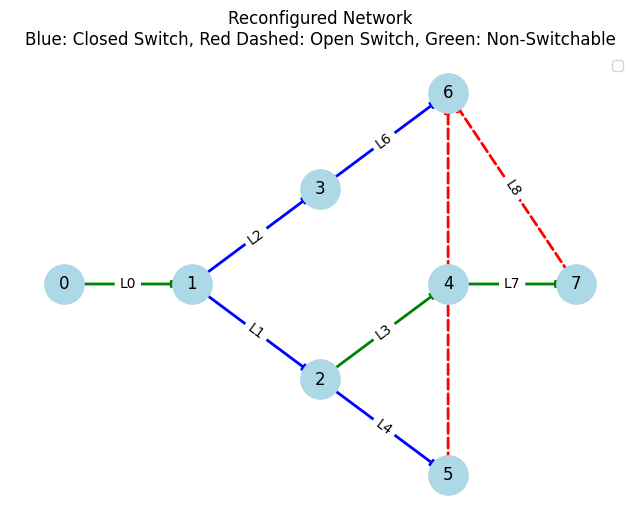

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def tree_layout(G, root=0):
    """Generate a tree-like layout using a breadth-first search from the root."""
    UG = G.to_undirected()
    queue = deque([root])
    visited = {root}
    level = {root: 0}
    while queue:
        u = queue.popleft()
        for v in UG[u]:
            if v not in visited:
                visited.add(v)
                level[v] = level[u] + 1
                queue.append(v)
    level_dict = {}
    for node, lv in level.items():
        level_dict.setdefault(lv, []).append(node)
    pos = {}
    for lv, nodes in level_dict.items():
        offset = -(len(nodes)-1)/2.0
        for i, node in enumerate(nodes):
            pos[node] = (lv, i+offset)
    return pos

def plot_solution_with_switch_status(instance):
    # Lists to store edges according to their type:
    closed_switch_edges = []
    open_switch_edges = []
    non_switchable_edges = []
    edge_labels = {}

    # Loop over each line
    for l in instance.L:
        edge = instance.F[l].first()  # forward direction (from_bus, to_bus)
        edge_labels[edge] = f"L{l}"
        if l in instance.S:
            # It's a switchable line: check the binary variable.
            status = instance.y_fixed[l]()
            if status == 1:
                closed_switch_edges.append(edge)
            else:
                open_switch_edges.append(edge)
        else:
            # Non-switchable lines are always active.
            non_switchable_edges.append(edge)

    # Create a graph containing all edges (for layout)
    G_all = nx.DiGraph()
    for i in instance.I:
        G_all.add_node(i)
    for edge in closed_switch_edges + open_switch_edges + non_switchable_edges:
        G_all.add_edge(*edge)
    pos = tree_layout(G_all, root=0)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G_all, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G_all, pos)
    
    # Draw edges with different styles:
    nx.draw_networkx_edges(G_all, pos, edgelist=closed_switch_edges,
                           edge_color='blue', arrows=True, width=2, label='Closed Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=open_switch_edges,
                           edge_color='red', style='dashed', arrows=True, width=2, label='Open Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=non_switchable_edges,
                           edge_color='green', arrows=True, width=2, label='Non-Switchable')

    nx.draw_networkx_edge_labels(G_all, pos, edge_labels=edge_labels)

    plt.title("Reconfigured Network\nBlue: Closed Switch, Red Dashed: Open Switch, Green: Non-Switchable")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()

# After solving the model instance, call:
plot_solution_with_switch_status(instance)


In [2]:
import pyomo.environ as pyo

# Create an AbstractModel
model = pyo.AbstractModel()

# -----------------------------
# 1. Sets and Parameters
# -----------------------------
# Bus set
model.I = pyo.Set()  

# Line set
model.L = pyo.Set()  

# Connectivity: for each line, an ordered pair (from, to)
model.F = pyo.Set(model.L, within=model.I * model.I, ordered=True)

# Switchable lines (subset of L)
model.S = pyo.Set(within=model.L)

# Non-switchable lines: computed from L \ S
model.nS = pyo.Set(initialize=lambda model: [l for l in model.L if l not in model.S])

# Line parameters: resistance (r) and reactance (x)
model.r = pyo.Param(model.L)
model.x = pyo.Param(model.L)

# Bus load parameters (real and reactive)
model.p_load = pyo.Param(model.I)
model.q_load = pyo.Param(model.I)

# -----------------------------
# 2. Decision Variables
# -----------------------------
# Real and reactive power flows on each line (in the designated forward direction)
model.P = pyo.Var(model.L, domain=pyo.Reals)
model.Q = pyo.Var(model.L, domain=pyo.Reals)

# Current squared (representing the squared current magnitude on each line)
model.f = pyo.Var(model.L, domain=pyo.NonNegativeReals)

# Binary switch variable for each switchable line (named z)
model.z = pyo.Var(model.S, domain=pyo.Binary)

# Expression for the active status of each line:
# Equals z if the line is switchable, and 1 if non-switchable.
def active_rule(model, l):
    if l in model.S:
        return model.z[l]
    else:
        return 1
# "active" is reserved; use "line_active" instead.
model.line_active = pyo.Expression(model.L, rule=active_rule)

# Bus squared voltage variables
model.v_sq = pyo.Var(model.I, domain=pyo.NonNegativeReals)

# -----------------------------
# 3. Helper Functions for Connectivity
# -----------------------------
def from_bus(model, l):
    return model.F[l].first()[0]

def to_bus(model, l):
    return model.F[l].first()[1]

# -----------------------------
# 4. Constraints
# -----------------------------

# (a) Slack Bus Voltage: assume bus 0 is the slack bus (v = 1.0 p.u.)
def slack_voltage_rule(model):
    return model.v_sq[0] == 1.0
model.slack_voltage = pyo.Constraint(rule=slack_voltage_rule)

# (b) Voltage Limits at Buses:
# Here we set limits to [0.9, 1.1] p.u. (squared limits: [0.9^2, 1.1^2])
vmin_sq = 0.9**2  # 0.81
vmax_sq = 1.1**2  # 1.21
def voltage_limit_rule(model, i):
    return pyo.inequality(vmin_sq, model.v_sq[i], vmax_sq)
model.voltage_limits = pyo.Constraint(model.I, rule=voltage_limit_rule)

# (c) Modified Power Balance Constraints (DistFlow formulation)
# For each non-slack bus, the incoming power (minus losses) minus the outgoing power equals the local load.
def power_balance_real_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming = sum(model.P[l] - model.r[l]*model.f[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.P[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.p_load[i]
model.power_balance_real = pyo.Constraint(model.I, rule=power_balance_real_rule)

def power_balance_reactive_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming = sum(model.Q[l] - model.x[l]*model.f[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.Q[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.q_load[i]
model.power_balance_reactive = pyo.Constraint(model.I, rule=power_balance_reactive_rule)

# (d) Radiality Constraint: each non-slack bus must have exactly one active incoming line.
def radiality_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming_active = sum(model.line_active[l] for l in model.L if to_bus(model, l) == i)
    return incoming_active == 1
model.radiality = pyo.Constraint(model.I, rule=radiality_rule)

# (e) Big‑M Constraints for flows and current:
M = 1e4  # Large constant
def bigM_P_upper_rule(model, l):
    return model.P[l] <= M * model.line_active[l]
model.bigM_P_upper = pyo.Constraint(model.L, rule=bigM_P_upper_rule)

def bigM_P_lower_rule(model, l):
    return model.P[l] >= -M * model.line_active[l]
model.bigM_P_lower = pyo.Constraint(model.L, rule=bigM_P_lower_rule)

def bigM_Q_upper_rule(model, l):
    return model.Q[l] <= M * model.line_active[l]
model.bigM_Q_upper = pyo.Constraint(model.L, rule=bigM_Q_upper_rule)

def bigM_Q_lower_rule(model, l):
    return model.Q[l] >= -M * model.line_active[l]
model.bigM_Q_lower = pyo.Constraint(model.L, rule=bigM_Q_lower_rule)

def bigM_f_rule(model, l):
    return model.f[l] <= M * model.line_active[l]
model.bigM_f = pyo.Constraint(model.L, rule=bigM_f_rule)

# (f) Voltage Drop Constraints (DistFlow Equation)
# When a line is active, enforce:
#   v_sq[to] = v_sq[from] - 2*(r*P + x*Q) + (r^2+x^2)*f
# To allow slight numerical deviations, we include a small tolerance ε.
epsilon = 1e-3

def voltage_drop_upper_rule(model, l):
    u = from_bus(model, l)
    d = to_bus(model, l)
    expr = model.v_sq[u] - 2*(model.r[l]*model.P[l] + model.x[l]*model.Q[l]) + (model.r[l]**2 + model.x[l]**2)*model.f[l]
    return model.v_sq[d] - expr <= epsilon + M*(1 - model.line_active[l])
model.voltage_drop_upper = pyo.Constraint(model.L, rule=voltage_drop_upper_rule)

def voltage_drop_lower_rule(model, l):
    u = from_bus(model, l)
    d = to_bus(model, l)
    expr = model.v_sq[u] - 2*(model.r[l]*model.P[l] + model.x[l]*model.Q[l]) + (model.r[l]**2 + model.x[l]**2)*model.f[l]
    return model.v_sq[d] - expr >= -epsilon - M*(1 - model.line_active[l])
model.voltage_drop_lower = pyo.Constraint(model.L, rule=voltage_drop_lower_rule)

# (g) SOC Constraint for Current:
# Enforce: P[l]^2 + Q[l]^2 <= f[l] * v_sq[from] when the line is active.
def soc_constraint_rule(model, l):
    u = from_bus(model, l)
    return model.P[l]**2 + model.Q[l]**2 <= model.f[l]*model.v_sq[u] + M*(1 - model.line_active[l])
model.soc_constraint = pyo.Constraint(model.L, rule=soc_constraint_rule)

# -----------------------------
# 5. Objective
# -----------------------------
# Minimize total line losses, approximated as the sum over lines of r * f.
def objective_rule(model):
    return sum(model.r[l] * model.f[l] for l in model.L)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# -----------------------------
# 6. Instance Data
# -----------------------------
# Note: The loads have been scaled down by a factor of 0.1 to reflect typical per-unit values.
data = {
    None: {
        # Bus set: buses 0 through 7
        'I': {None: [0, 1, 2, 3, 4, 5, 6, 7]},
        # Line set: 9 lines
        'L': {None: list(range(9))},
        # Connectivity for each line (first tuple is the "from" bus)
        'F': {
            0: [(0, 1), (1, 0)],
            1: [(1, 2), (2, 1)],
            2: [(1, 3), (3, 1)],
            3: [(2, 4), (4, 2)],
            4: [(2, 5), (5, 2)],
            5: [(5, 6), (6, 5)],
            6: [(3, 6), (6, 3)],
            7: [(4, 7), (7, 4)],
            8: [(7, 6), (6, 7)]
        },
        # Switchable lines (indices from the line set)
        'S': {None: [1, 2, 4, 5, 6, 8]},
        # Line parameters: resistances and reactances for each line
        'r': {0: 0.01, 1: 0.02, 2: 0.02, 3: 0.03, 4: 0.03, 5: 0.01, 6: 0.02, 7: 0.02, 8: 0.04},
        'x': {0: 0.05, 1: 0.04, 2: 0.04, 3: 0.05, 4: 0.05, 5: 0.02, 6: 0.03, 7: 0.03, 8: 0.06},
        # Bus loads (real and reactive), scaled by 0.1
        'p_load': {0: 0.0, 1: 0.1, 2: 0.12, 3: 0.15, 4: 0.08, 5: 0.1, 6: 0.12, 7: 0.06},
        'q_load': {0: 0.0, 1: 0.03, 2: 0.04, 3: 0.05, 4: 0.02, 5: 0.03, 6: 0.04, 7: 0.02},
    }
}

instance = model.create_instance(data)

# -----------------------------
# 7. Solve the Model
# -----------------------------
solver = pyo.SolverFactory('gurobi')
results = solver.solve(instance, tee=True)
instance.display()


Read LP format model from file /tmp/tmpqa4ujhnn.pyomo.lp
Reading time = 0.00 seconds
x1: 101 rows, 42 columns, 252 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 101 rows, 42 columns and 252 nonzeros
Model fingerprint: 0xff27eb1c
Model has 9 quadratic constraints
Variable types: 36 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+04, 1e+04]
  Objective range  [1e-02, 4e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 59 rows and 5 columns
Presolve time: 0.01s
Presolved: 52 rows, 49 columns, 203 nonzeros
Presolved model has 13 quadratic constraint(s)
Presolved model has 3 bilinear constraint(

In [ ]:
import pyomo.environ as pyo

# Create an AbstractModel
model = pyo.AbstractModel()

# -----------------------------
# 1. Sets and Parameters
# -----------------------------
# Bus set
model.I = pyo.Set()  

# Line set
model.L = pyo.Set()  

# Connectivity: for each line, an ordered pair (from, to)
model.F = pyo.Set(model.L, within=model.I * model.I, ordered=True)

# Switchable lines (subset of L)
model.S = pyo.Set(within=model.L)

# Non-switchable lines: computed from L \ S
model.nS = pyo.Set(initialize=lambda model: [l for l in model.L if l not in model.S])

# Line parameters: resistance (r) and reactance (x)
model.r = pyo.Param(model.L)
model.x = pyo.Param(model.L)

# Bus load parameters (real and reactive)
model.p_load = pyo.Param(model.I)
model.q_load = pyo.Param(model.I)

# -----------------------------
# 2. Decision Variables
# -----------------------------
# Real and reactive power flows on each line (in the designated forward direction)
model.P = pyo.Var(model.L, domain=pyo.Reals)
model.Q = pyo.Var(model.L, domain=pyo.Reals)

# Current squared (representing the squared current magnitude on each line)
model.f = pyo.Var(model.L, domain=pyo.NonNegativeReals)

# Binary switch variable for each switchable line (named z)
model.z = pyo.Var(model.S, domain=pyo.Binary)

# Expression for the active status of each line:
# Equals z if the line is switchable, and 1 if non-switchable.
def active_rule(model, l):
    if l in model.S:
        return model.z[l]
    else:
        return 1
# "active" is reserved; use "line_active" instead.
model.line_active = pyo.Expression(model.L, rule=active_rule)

# Bus squared voltage variables
model.v_sq = pyo.Var(model.I, domain=pyo.NonNegativeReals)

# -----------------------------
# 3. Helper Functions for Connectivity
# -----------------------------
def from_bus(model, l):
    return model.F[l].first()[0]

def to_bus(model, l):
    return model.F[l].first()[1]

# -----------------------------
# 4. Constraints
# -----------------------------

# (a) Slack Bus Voltage: assume bus 0 is the slack bus (v = 1.0 p.u.)
def slack_voltage_rule(model):
    return model.v_sq[0] == 1.0
model.slack_voltage = pyo.Constraint(rule=slack_voltage_rule)

# (b) Voltage Limits at Buses:
# Limits [0.9, 1.1] p.u. 
vmin_sq = 0.9**2  # 0.81
vmax_sq = 1.1**2  # 1.21
def voltage_limit_rule(model, i):
    return pyo.inequality(vmin_sq, model.v_sq[i], vmax_sq)
model.voltage_limits = pyo.Constraint(model.I, rule=voltage_limit_rule)

# (c) Modified Power Balance Constraints (DistFlow formulation)
def power_balance_real_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming = sum(model.P[l] - model.r[l]*model.f[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.P[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.p_load[i]
model.power_balance_real = pyo.Constraint(model.I, rule=power_balance_real_rule)

def power_balance_reactive_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming = sum(model.Q[l] - model.x[l]*model.f[l] for l in model.L if to_bus(model, l) == i)
    outgoing = sum(model.Q[l] for l in model.L if from_bus(model, l) == i)
    return incoming - outgoing == model.q_load[i]
model.power_balance_reactive = pyo.Constraint(model.I, rule=power_balance_reactive_rule)

# (d) tree base Constraint: each non-slack bus must have exactly one active incoming line.
def radiality_rule(model, i):
    if i == 0:
        return pyo.Constraint.Skip
    incoming_active = sum(model.line_active[l] for l in model.L if to_bus(model, l) == i)
    return incoming_active == 1
model.radiality = pyo.Constraint(model.I, rule=radiality_rule)

# (e) Big‑M Constraints for flows and current:
M = 1e4  # Large constant
def bigM_P_upper_rule(model, l):
    return model.P[l] <= M * model.line_active[l]
model.bigM_P_upper = pyo.Constraint(model.L, rule=bigM_P_upper_rule)

def bigM_P_lower_rule(model, l):
    return model.P[l] >= -M * model.line_active[l]
model.bigM_P_lower = pyo.Constraint(model.L, rule=bigM_P_lower_rule)

def bigM_Q_upper_rule(model, l):
    return model.Q[l] <= M * model.line_active[l]
model.bigM_Q_upper = pyo.Constraint(model.L, rule=bigM_Q_upper_rule)

def bigM_Q_lower_rule(model, l):
    return model.Q[l] >= -M * model.line_active[l]
model.bigM_Q_lower = pyo.Constraint(model.L, rule=bigM_Q_lower_rule)

def bigM_f_rule(model, l):
    return model.f[l] <= M * model.line_active[l]
model.bigM_f = pyo.Constraint(model.L, rule=bigM_f_rule)

# (f) Voltage Drop Constraints (DistFlow Equation)
# When a line is active, enforce:
#   v_sq[to] = v_sq[from] - 2*(r*P + x*Q) + (r^2+x^2)*f
def voltage_drop_upper_rule(model, l):
    u = from_bus(model, l)
    d = to_bus(model, l)
    expr = model.v_sq[u] - 2*(model.r[l]*model.P[l] + model.x[l]*model.Q[l]) + (model.r[l]**2 + model.x[l]**2)*model.f[l]
    # When line is active: (1 - line_active[l]) = 0 so v_sq[d] == expr.
    return model.v_sq[d] - expr <= M*(1 - model.line_active[l])
model.voltage_drop_upper = pyo.Constraint(model.L, rule=voltage_drop_upper_rule)

def voltage_drop_lower_rule(model, l):
    u = from_bus(model, l)
    d = to_bus(model, l)
    expr = model.v_sq[u] - 2*(model.r[l]*model.P[l] + model.x[l]*model.Q[l]) + (model.r[l]**2 + model.x[l]**2)*model.f[l]
    return model.v_sq[d] - expr >= -M*(1 - model.line_active[l])
model.voltage_drop_lower = pyo.Constraint(model.L, rule=voltage_drop_lower_rule)

# (g) SOC Constraint for Current:
# Enforce: P[l]^2 + Q[l]^2 <= f[l] * v_sq[from] when the line is active.
def soc_constraint_rule(model, l):
    u = from_bus(model, l)
    return model.P[l]**2 + model.Q[l]**2 <= model.f[l]*model.v_sq[u] + M*(1 - model.line_active[l])
model.soc_constraint = pyo.Constraint(model.L, rule=soc_constraint_rule)

# -----------------------------
# 5. Objective
# -----------------------------
# Minimize total line losses, approximated as the sum over lines of r * f.
def objective_rule(model):
    return sum(model.r[l] * model.f[l] for l in model.L)
model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# -----------------------------
# 6. Instance Data
# -----------------------------
data = {
    None: {
        # Bus set: buses 0 through 7
        'I': {None: [0, 1, 2, 3, 4, 5, 6, 7]},
        # Line set: 9 lines
        'L': {None: list(range(9))},
        # Connectivity for each line (first tuple is the "from" bus)
        'F': {
            0: [(0, 1), (1, 0)],
            1: [(1, 2), (2, 1)],
            2: [(1, 3), (3, 1)],
            3: [(2, 4), (4, 2)],
            4: [(2, 5), (5, 2)],
            5: [(5, 6), (6, 5)],
            6: [(3, 6), (6, 3)],
            7: [(4, 7), (7, 4)],
            8: [(7, 6), (6, 7)]
        },
        # Switchable lines (indices from the line set)
        'S': {None: [1, 2, 4, 5, 6, 8]},
        # Line parameters: resistances and reactances for each line
        'r': {0: 0.01, 1: 0.02, 2: 0.02, 3: 0.03, 4: 0.03, 5: 0.01, 6: 0.02, 7: 0.02, 8: 0.04},
        'x': {0: 0.05, 1: 0.04, 2: 0.04, 3: 0.05, 4: 0.05, 5: 0.02, 6: 0.03, 7: 0.03, 8: 0.06},
        # Bus loads (real and reactive), scaled by 0.1
        'p_load': {0: 0.0, 1: 0.1, 2: 0.12, 3: 0.15, 4: 0.08, 5: 0.1, 6: 0.12, 7: 0.06},
        'q_load': {0: 0.0, 1: 0.03, 2: 0.04, 3: 0.05, 4: 0.02, 5: 0.03, 6: 0.04, 7: 0.02},
    }
}

instance = model.create_instance(data)

# -----------------------------
# 7. Solve the Model
# -----------------------------
solver = pyo.SolverFactory('gurobi')
results = solver.solve(instance, tee=True)
instance.display()


Read LP format model from file /tmp/tmp7dh68cht.pyomo.lp
Reading time = 0.00 seconds
x1: 101 rows, 42 columns, 252 nonzeros
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: Intel(R) Core(TM) i7-4790 CPU @ 3.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 101 rows, 42 columns and 252 nonzeros
Model fingerprint: 0x4f3443a3
Model has 9 quadratic constraints
Variable types: 36 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [5e-04, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+04, 1e+04]
  Objective range  [1e-02, 4e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 1e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 65 rows and 5 columns
Presolve time: 0.00s
Presolved: 46 rows, 49 columns, 171 nonzeros
Presolved model has 13 quadratic constraint(s)
Presolved model has 3 bilinear constraint(

/tmp/ipykernel_1855946/168016092.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(scatterpoints=1)


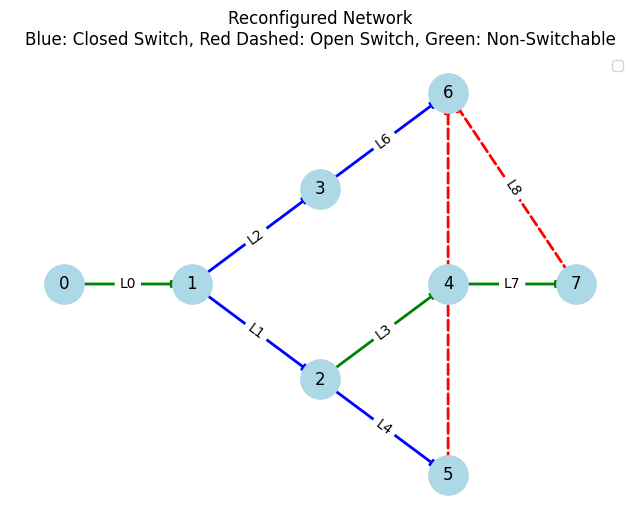

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque

def tree_layout(G, root=0):
    """Generate a tree-like layout using a breadth-first search from the root."""
    UG = G.to_undirected()
    queue = deque([root])
    visited = {root}
    level = {root: 0}
    while queue:
        u = queue.popleft()
        for v in UG[u]:
            if v not in visited:
                visited.add(v)
                level[v] = level[u] + 1
                queue.append(v)
    level_dict = {}
    for node, lv in level.items():
        level_dict.setdefault(lv, []).append(node)
    pos = {}
    for lv, nodes in level_dict.items():
        offset = -(len(nodes)-1)/2.0
        for i, node in enumerate(nodes):
            pos[node] = (lv, i + offset)
    return pos

def plot_solution_with_switch_status(instance):
    # Lists to store edges according to their type:
    closed_switch_edges = []
    open_switch_edges = []
    non_switchable_edges = []
    edge_labels = {}

    # Loop over each line
    for l in instance.L:
        edge = instance.F[l].first()  # forward direction (from_bus, to_bus)
        edge_labels[edge] = f"L{l}"
        if l in instance.S:
            # It's a switchable line: check the binary variable z.
            status = instance.z[l]()  # call the Pyomo variable
            if status == 1:
                closed_switch_edges.append(edge)
            else:
                open_switch_edges.append(edge)
        else:
            # Non-switchable lines are always active.
            non_switchable_edges.append(edge)

    # Create a graph containing all edges (for layout)
    G_all = nx.DiGraph()
    for i in instance.I:
        G_all.add_node(i)
    for edge in closed_switch_edges + open_switch_edges + non_switchable_edges:
        G_all.add_edge(*edge)
    pos = tree_layout(G_all, root=0)

    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G_all, pos, node_size=800, node_color='lightblue')
    nx.draw_networkx_labels(G_all, pos)
    
    # Draw edges with different styles:
    nx.draw_networkx_edges(G_all, pos, edgelist=closed_switch_edges,
                           edge_color='blue', arrows=True, width=2, label='Closed Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=open_switch_edges,
                           edge_color='red', style='dashed', arrows=True, width=2, label='Open Switch')
    nx.draw_networkx_edges(G_all, pos, edgelist=non_switchable_edges,
                           edge_color='green', arrows=True, width=2, label='Non-Switchable')

    nx.draw_networkx_edge_labels(G_all, pos, edge_labels=edge_labels)

    plt.title("Reconfigured Network\nBlue: Closed Switch, Red Dashed: Open Switch, Green: Non-Switchable")
    plt.axis('off')
    plt.legend(scatterpoints=1)
    plt.show()

# After solving the model instance, call:
plot_solution_with_switch_status(instance)


In [3]:
import pandas as pd
import pyomo.environ as pyo

# Extract and print bus voltages
bus_voltage_data = []
for i in instance.I:
    voltage_val = pyo.value(instance.v_sq[i])
    bus_voltage_data.append({'Bus': i, 'Voltage^2 (p.u.)': voltage_val})
df_voltages = pd.DataFrame(bus_voltage_data)
print("Bus Voltages:")
print(df_voltages)

# Extract and print line flows and switch status
line_data = []
for l in instance.L:
    P_val = pyo.value(instance.P[l])
    Q_val = pyo.value(instance.Q[l])
    f_val = pyo.value(instance.f[l])
    # For switchable lines, retrieve the binary variable; for non-switchable lines, use 1
    if l in instance.S:
        z_val = pyo.value(instance.z[l])
    else:
        z_val = 1
    line_data.append({
        'Line': l,
        'P (MW)': P_val,
        'Q (MVAr)': Q_val,
        'Current^2 (I^2)': f_val,
        'Switch (z)': z_val
    })
df_lines = pd.DataFrame(line_data)
print("\nLine Flows and Switch Status:")
print(df_lines)


Bus Voltages:
   Bus  Voltage^2 (p.u.)
0    0          1.000000
1    1          0.959453
2    2          0.935753
3    3          0.941225
4    4          0.923256
5    5          0.926713
6    6          0.934003
7    7          0.919650

Line Flows and Switch Status:
   Line    P (MW)  Q (MVAr)  Current^2 (I^2)  Switch (z)
0     0  0.742514  0.273246         0.625991         1.0
1     1  0.364185  0.117978         0.152743         1.0
2     2  0.272070  0.093968         0.086353         1.0
3     3  0.140777  0.041280         0.023000         1.0
4     4  0.100353  0.030588         0.011762         1.0
5     5  0.000000  0.000000         0.000000        -0.0
6     6  0.120343  0.040514         0.017130         1.0
7     7  0.060087  0.020130         0.004349         1.0
8     8  0.000000  0.000000         0.000000        -0.0
